# Final Exam CS/INFO 662/762 Fall 2023
CS/INFO 762: 100 points ; CS/INFO 662  90 points

### <font color='red'>Due Dec 9th, 11:59am</font> - Submission via Canvas (.ipynb file)

## STUDENT NAME: <font color='red'>MICHAEL GATHARA</font>


* Question 1a: Medical Mention Normalization with SAPBERT (PhD Students must include one graph feature) - 35/25 points
* Question 1b: Compute Recall - 15 points
* Question 1c: Random Forest: Feature Importance - 10 points
* Question 2: Language Model Questions (Long Written Answer) - 40 points

<font color='red'>As always WORK ON YOUR OWN for this final exam. Like last year, the final exam will be run through plagarism detection software. You may email me for clarification, but don't post on Stack Overflow, Quota, Reddit, etc..  You MAY use ChatGPT for ANY question, but the usual rules for citation and prompt inclusion in your answer apply.</font>


## Imports (if needed)

In [ ]:
# If needed
#!pip uninstall --yes flair
!pip install obonet
!pip install py-rouge
!pip install node2vec
!pip install rouge-score


In [1]:
import time
import networkx
import obonet
import os
from nltk.corpus import stopwords  
from nltk.tokenize import word_tokenize
from rouge_score import rouge_scorer
import numpy as np
import heapq
import pandas as pd
#import scispacy
import spacy
import numpy as np
import torch
from io import StringIO
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModel  

tokenizer = AutoTokenizer.from_pretrained("cambridgeltl/SapBERT-from-PubMedBERT-fulltext")  
model = AutoModel.from_pretrained("cambridgeltl/SapBERT-from-PubMedBERT-fulltext").cuda()

do_url = 'https://raw.githubusercontent.com/DiseaseOntology/HumanDiseaseOntology/main/src/ontology/HumanDO.obo'
hpo_url = 'http://purl.obolibrary.org/obo/hp.obo'
do = obonet.read_obo(do_url)
hpo = obonet.read_obo(hpo_url)
print('Disease Ontology is currently size:'+str(len(do))+" with "+str(do.number_of_edges())+' edges')
print('Human Phenotype Ontology is currently size:'+str(len(hpo))+" with "+str(hpo.number_of_edges())+' edges')

Disease Ontology is currently size:11432 with 11462 edges
Human Phenotype Ontology is currently size:17664 with 21975 edges


## Question 1 - Concept Normalization
This question requires you to write use the SAPBERT embeddings you are familiar with from assignment #2 to generate candidate concepts for each input medical mentions for a merged overlapping knowledge graph of both the Disease Ontology (DO) and Human Phenotyper Ontology (HPO). 

### Set Up Knowledge Graph and Corpus Preparation 
This code is provided to you and creates:
* The merged knowledge graph (kgs) from the both Disease Ontology (DO) and the Human Phenotype Ontology (HPO) as a dataframe. You also have access to the original graphs in obo format to get graph features, for example you can use node2vec.
* The input corpus and medical mentions (labelled data) as a dataframe, "mention_mapping". It is built from the input corpus and you can assume that NER has already been done to identify the mentions to map. They are in the "mention" column and the correct concept (CUI) it should be mapped to is in the "CUI" column. 


In [2]:
def createIndex(graph,prefix):
    id2cui = {}
    cui2id = {}
    id_to_xref = {id_: data.get('xref') for id_, data in graph.nodes(data=True)}
    for graph_id,xrefs in id_to_xref.items():
        if(xrefs is None):
            cui = None
        else:
            cui = next((x for x in xrefs if x.startswith(prefix)),None)
            if(cui is not None):
                cui = cui.replace(prefix,'')
        id2cui[graph_id]=cui
        if(cui is not None):
            cui2id[cui]=graph_id
    return(id2cui,cui2id)


def convertCui2Doid(cui):
    if cui in cui2do:
        return cui2do[cui]
    return None

def hpoId2Name(oboid):
    return hpoid_to_name[oboid]

def doId2Name(oboid):
    if(oboid is None):
        return None
    if (doid_to_name[oboid]):
        return doid_to_name[oboid]
    else:
        return None


def get_mentions(filename,bardoc):
    all_mentions = []
    with open(filename, 'r') as file: 
        textdoc = file.read()
        for line in bardoc.splitlines():
            #print(line)
            start = int(line.split("||")[2])
            stop = int(line.split("||")[3])
            mention = textdoc[start:stop]
            if(not line.endswith("||||||")):
                start = int(line.split("||")[4])
                stop = int(line.split("||")[5])
                extramention = textdoc[start:stop]
                mention = mention+' '+extramention
                if(not line.endswith("||||")):
                    start = int(line.split("||")[6])
                    stop = int(line.split("||")[7])
                    extramention = textdoc[start:stop]
                    mention = mention+' '+extramention
            #print(mention)
            all_mentions.append(mention)
    return all_mentions

def read_files(directory):
    all_data = []
    for file in os.listdir(directory):
        #print(file)
        if file.endswith(".norm"):
            file_path = os.path.join(directory, file)
            with open(file_path, 'r') as file:
                csv_string = file.read()
            #normed = [line+"||||" for line in csv_string.splitlines() if line.count('|')==6]
            normed = [line if line.count('|') == 14 else (line+"||||" if line.count('|') == 10 else line+"||||||||") for line in csv_string.splitlines()]
            clean = '\n'.join(normed)
            note_file = (str(file.name).replace("train_norm","train_note").replace("norm","txt"))
            mentions = get_mentions(note_file,clean)
            df = pd.read_csv(StringIO(clean),engine='python',names=['ID', 'CUI', 'start1', 'stop1','start2','stop2','start3','stop3'],sep="\|\|")
            df['mention']=mentions
        all_data.append(df)
    return pd.concat(all_data, ignore_index=True)


hpo2cui,cui2hpo = createIndex(hpo,'UMLS:')
do2cui,cui2do = createIndex(do,'UMLS_CUI:')

hpoid_to_name = {id_: data.get('name') for id_, data in hpo.nodes(data=True)}
doid_to_name = {id_: data.get('name') for id_, data in do.nodes(data=True)}

df = pd.DataFrame(list(hpo2cui.items()))
df.columns=['HPOID','CUI']
df['DOID'] = df['CUI'].apply(convertCui2Doid)
df['HPO:Name'] = df['HPOID'].apply(hpoId2Name)
df['DO:Name'] = df['DOID'].apply(doId2Name)
hpokg = df.copy()
print("HPO Vocabulary: hpokg")
print(hpokg)
kgs = df.mask(df.eq('None')).dropna()

# Graph properties that may be useful
id_to_isa = {id_: data.get('is_a') for id_, data in hpo.nodes(data=True)}
id_to_xref = {id_: data.get('xref') for id_, data in do.nodes(data=True)}
result = next(iter(id_to_xref.values()))   

print("HPO and DO Joint Vocabulary:kgs")
print(kgs)
mention_mapping = read_files("train/train_norm/")
print("Input Corpus Mentions:mention_mapping")
mention_mapping

HPO Vocabulary: hpokg
            HPOID       CUI  DOID                          HPO:Name DO:Name
0      HP:0000001  C0444868  None                               All    None
1      HP:0000002  C4025901  None        Abnormality of body height    None
2      HP:0000003  C3714581  None      Multicystic kidney dysplasia    None
3      HP:0000005  C1708511  None               Mode of inheritance    None
4      HP:0000006  C0443147  None    Autosomal dominant inheritance    None
...           ...       ...   ...                               ...     ...
17659  HP:5201010      None  None  Microform cleft of the upper lip    None
17660  HP:5201011      None  None      Complete bilateral cleft lip    None
17661  HP:5201012      None  None    Incomplete bilateral cleft lip    None
17662  HP:5201013      None  None     Microform bilateral cleft lip    None
17663  HP:5201014      None  None    Asymmetric bilateral cleft lip    None

[17664 rows x 5 columns]
HPO and DO Joint Vocabulary:kgs
        

,ID,CUI,start1,stop1,start2,stop2,start3,stop3,mention
0,N000,C0011854,248,283,NaN,NaN,NaN,NaN,insulin dependent diabetes mellitus
1,N001,C4303631,298,327,NaN,NaN,NaN,NaN,a right above-knee amputation
2,N003,C0085671,537,553,NaN,NaN,NaN,NaN,dressing changes
3,N004,C0011079,558,569,NaN,NaN,NaN,NaN,debridement
4,N005,C0003232,611,622,NaN,NaN,NaN,NaN,antibiotics
...,...,...,...,...,...,...,...,...,...
6679,N139,C0442519,4695,4699,NaN,NaN,NaN,NaN,home
6680,N140,C0699203,4731,4737,NaN,NaN,NaN,NaN,motrin
6681,N141,C0593507,4740,4745,NaN,NaN,NaN,NaN,advil
6682,N142,C0332575,4863,4870,NaN,NaN,NaN,NaN,redness


## Question 1a: Generation of Candidate Concepts and their Features (35 points PhD/ 25 points MS)


#### Write code to find the best N candidate concepts for the mention using SAPBERT in the small (for final exam performance purposes) merged kgs vocabularuy.

The signature of the function should look something like this:
``` 
def getCandidates(mention_embeddings, vocabulary_embeddings, max_candidates):
```
* mention_embeddings would be SAPBERT embeddings of the mentions
* vocabulary_embeddings would be SAPBERT embeddings of the kgs vocabulary. You generate them using just DO concept text, just HPO concept text or perform a function to aggregate them.
* max_candidates (max candidates to return from kgs)

This function returns a list of the best N matches between the mention and the target merged knowledge graph based on feature similarity between the input node and the target node. Each match in the list is a tuple can contain any elements you need, but it should at least contain
 * a reference to the target concept, ie) row index|vocabulary_id
 * score (optional) or anything else you think you need
 
 
#### Write code to get a set of features for each candidate concepts that can be used for ranking the top N concepts to pick the most correct concept
The getFeatures function should generate features for an input mention text and one possible candidate mapping.
```
def getFeatures(mention_text, candidate_tuple_from_getCandidates)
```
These features will be used in Part 1b) to generate training data for a machine learning ranking algorithm.

Masters student need at least 2 features in their getFeatures code, some examples of lexical features include:
* counts of matching words or characters
* longest common subsequence (RougeL)
* ngram overlap, etc...

PhD Students will need an additional graph-based feature using relations in the ontology or ontology node vector representations such as node2vec. For example, one relevant feature may be checking the similarity of the input node to the parent node of the target. They can also be generated per random-walks like node2vec.


Hints:
 * stop words, stemming, lemmatizationm, headword matching are nice but not required for this tiny (mostly matching) gold data set
 * my advice is to do the minimal amount of work and come back later if you want to add more features
 * you may use ANY additional libraries as need

In [3]:
%%time
from numpy.linalg import norm
from sklearn.metrics.pairwise import cosine_similarity
from rouge_score import rouge_scorer
from nltk import ngrams

# Candidate Generation Code
def getCandidates(mention_embeddings, vocabulary_embeddings, max_candidates):
    # Compute cosine similarity between mention_embeddings and vocabulary_embeddings
    similarities = cosine_similarity(mention_embeddings.reshape(1, -1), vocabulary_embeddings)[0]
    similarities = similarities.flatten()  # Flatten the similarity matrix
    
    # Get indices of top N similar concepts
    top_indices = np.argsort(similarities)[::-1][:max_candidates]
    
    # Create a list of candidate tuples with required information (e.g., index and score)
    candidate_list = [(index, similarities[index]) for index in top_indices]
    
    return candidate_list

def getFeatures(mention_text, candidate_tuple_from_getCandidates):
    # Unpack candidate information (e.g., index and score)
    candidate_index, similarity_score = candidate_tuple_from_getCandidates
    
    # Get the candidate concept based on its index
    candidate_concept = kgs.iloc[candidate_index]  # Assuming kgs is accessible
    
    # Placeholder code for feature extraction, replace with actual feature engineering
    # Example features: RougeL score and ngram overlap
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=False)
    rouge_l_score = scorer.score(candidate_concept['DO:Name'], mention_text)['rougeL'].fmeasure
    
    mention_tokens = mention_text.lower().split()
    candidate_tokens = candidate_concept['DO:Name'].lower().split()
    
    ngram_overlap = len(set(ngrams(mention_tokens, 2)).intersection(set(ngrams(candidate_tokens, 2))))
    
    # You can add more features as needed
    
    return {'RougeL_Score': rouge_l_score, 'Ngram_Overlap': ngram_overlap}

CPU times: user 28 µs, sys: 0 ns, total: 28 µs
Wall time: 31.2 µs


## Question 1b: Compute Recall@3 and Generate Data for ML Algorithm in Part 1c (15 points)
 * Use your function in Part 1a) to generate 3 candidates for every mention and compute recall at n=3 candidates (For each mention, what is the fraction of times that the getCandidates returned the correct concept (CUI)?). Your re-ranking algorithm will not be able to do better than this. (5 points)
 * Many mentions represent concepts not included in our small merged kgs. Despite this, your recall performance may still not match your expectations using just SAPBERT embeddings. Explain why this might be (5 points).  
 * Create a labelled candidate ranking data set (5 points). For each mention, there will be 3 examples of which only 1 will have the correct CUI. Each example will have features (X) from part 1a and a label (Y). The label will be 1 if the features are sourced from the correct CUI and 0 if not. Use your getFeatures function to populate X. 



In [10]:
def get_embeddings(text, device='cuda'):
    # Tokenize the input text using the provided tokenizer
    tokens = tokenizer.encode_plus(text, return_tensors='pt', max_length=512, truncation=True)
    
    # Move the input tokens to the specified device (cuda/cpu)
    tokens = {key: value.to(device) for key, value in tokens.items()}
    
    # Forward pass the tokens through the model to get the embeddings
    with torch.no_grad():
        outputs = model(**tokens)
    
    # Move the embeddings to CPU if the output is on CUDA
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().detach().cpu().numpy()
    
    return embeddings

In [11]:
vocabulary_texts = list(kgs['DO:Name'])  # Assuming 'DO:Name' contains the text data for vocabulary

# Generate SAPBERT embeddings for the vocabulary texts
vocabulary_embeddings = []
for text in tqdm(vocabulary_texts):
    embedding = get_embeddings(text)
    vocabulary_embeddings.append(embedding)
    
mention_embeddings = []
for text in tqdm(mention_mapping['mention']):
    embedding = get_embeddings(text)
    mention_embeddings.append(embedding)

  0%|          | 0/970 [00:00<?, ?it/s]

  0%|          | 0/6684 [00:00<?, ?it/s]

In [12]:
vocabulary_embeddings = np.array(vocabulary_embeddings)
# mention_embeddings = np.array(mention_embeddings)

In [14]:
%%time
# Compute Recall for Candidate Generation Code
X = []
Y = []

# Create X (data), Y (label) for ranking algorithm.
# Initialize variables to track recall calculation
total_mentions = len(mention_mapping)
correct_candidates = 0

# Loop through each mention and compute recall at n=3 candidates
for mention in tqdm(mention_mapping['mention']):
    mention_embedding = get_embeddings(mention)
    
    # Get candidates for the mention
    candidates = getCandidates(mention_embedding, vocabulary_embeddings, 3)
    
    # Retrieve correct CUI for the mention
    correct_cui = mention_mapping[mention_mapping['mention'] == mention]['CUI'].values[0]
    
    # Check if correct CUI is in the top 3 candidates
    top_candidates = [kgs.iloc[candidate[0]]['CUI'] for candidate in candidates]
    if correct_cui in top_candidates:
        correct_candidates += 1

# Compute recall at n=3 candidates
recall_at_3 = correct_candidates / total_mentions
print(f"Recall at 3 candidates: {recall_at_3}")


  0%|          | 0/6684 [00:00<?, ?it/s]

Recall at 3 candidates: 0.06149012567324955
CPU times: user 1min, sys: 238 ms, total: 1min
Wall time: 1min


In [16]:
X = []
Y = []

# Loop through mentions to generate labeled dataset samples
for mention in tqdm(mention_mapping['mention']):
    mention_text = mention_mapping[mention_mapping['mention'] == mention]['mention'].values[0]
    mention_embedding = get_embeddings(mention)
    
    # Get candidates for the mention
    candidates = getCandidates(mention_embedding, vocabulary_embeddings, 3)
    
    # Retrieve correct CUI for the mention
    correct_cui = mention_mapping[mention_mapping['mention'] == mention]['CUI'].values[0]
    
    # Create labeled samples for each candidate
    for candidate in candidates:
        candidate_index, _ = candidate
        candidate_cui = kgs.iloc[candidate_index]['CUI']

        # Generate features for the candidate
        candidate_features = getFeatures(mention_text, candidate)

        # Assign label based on correct CUI match
        label = 1 if candidate_cui == correct_cui else 0

        # Append features and label to the dataset
        X.append(candidate_features)
        Y.append(label)

# Convert X and Y lists to pandas DataFrame
dataset = pd.DataFrame(X)
dataset['Label'] = Y

  0%|          | 0/6684 [00:00<?, ?it/s]

## Question 1c: Random Forest Candidate Ranker and Feature Analysis (10 points)

 * Split your data into training and testing data and then train scikit-learn's RandomForestClassifier to predict if a candidate node is the correct match. Output a classification report with accuracy.
 
 * Use scikit-learn's RandomForestClassifier to compute the relative importance of your features for this algorithm and graph them. Give your features reasonable names so they look nice on a graph.

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3937
           1       0.98      0.57      0.72        74

    accuracy                           0.99      4011
   macro avg       0.98      0.78      0.86      4011
weighted avg       0.99      0.99      0.99      4011

Accuracy: 0.9917726252804787


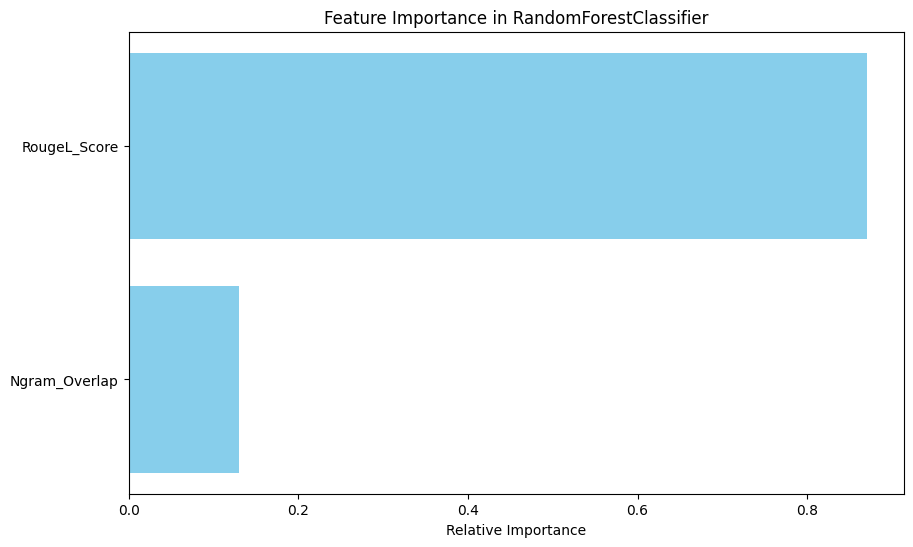

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset.drop(columns=['Label']), dataset['Label'], test_size=0.2, random_state=42)

# Initialize RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the RandomForestClassifier
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Generate classification report and accuracy
classification_rep = classification_report(y_test, y_pred)
accuracy = rf_classifier.score(X_test, y_test)
print(f"Classification Report:\n{classification_rep}")
print(f"Accuracy: {accuracy}")

# Calculate feature importance
feature_importance = rf_classifier.feature_importances_

# Get feature names from the dataset
feature_names = X_train.columns

# Create a DataFrame of feature importance for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Relative Importance')
plt.title('Feature Importance in RandomForestClassifier')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()



## Question 2a (20 points)

One of the issues with medical normalization is that training data is sparse, some disease are over-represented, whereas some rare disease have a dictionary entry but few examples in clinical text. Making at least one reference to a paper discussed in class:


* Describe how you could use a LLM (like GPT-4) to generate a synthetic corpus for concept normalization to an ontology like the Human Phenotype Ontology described here? Assume you would like to generate synthetic data for concepts not included in typical training data. (10 points)


* Propose an evaluation method for your synthetic text generation method. How would you evaluate whether your approach is successfull? (10 points)



## <font color="red">Describe how you could use a LLM (like GPT-4) to generate a synthetic corpus for concept normalization to an ontology like the Human Phenotype Ontology described here? Assume you would like to generate synthetic data for concepts not included in typical training data. (10 points)</font>
<br>
<br>
The best thing about GPT4 is that it excels in text generation. This makes it perfect for generating synthetic corpora. One of the biggest problems is that it needs a couple examples of data to copy as the accuracy increases with more examples, often called x-shot prompting. As the data is already rare, it may be hard to find examples unless a doctor/specialist feeds it data. This is well highlighted in the paper <font color="red">Can Synthetic Text Help Clinical Named Entity Recognition? A Study of Electronic Health Records in French</font> (Hiebel et al., 2023). The paper highlights the generation of data automatically, but touches on the difficulty of evaluating this data. 

## <font color="red">Propose an evaluation method for your synthetic text generation method. How would you evaluate whether your approach is successfull? (10 points)</font>

There are two modes of evaluation that we have to consider. Intrinsic and Extrinsic. Whereas intrinsic evaluation is evaluated against some predetermined ground truth and extrensic evaluation is evaluated based on its impact on the performance of other systems.

* <font color="red">Intrinsic Evaluation</font>
In terms of intrinsic evaluation, it is a bit more difficult since this requires a ground truth to compare against and we do not have a lot of truth data on rare diseases. In the paper above, they suggest evaluating using ngram overlap and named entity recognition. These two methods already offer a great way to evaluate the data; However, I would also propose that a researcher to look into utilizing Ontology coverage whereas the breadth of the HPO ensures the presence and frequency of the new terms in the corpora are represented adequately. One may also consider use-case simulation whereas you simulate utilizing the new findings to make clinical decisions which are similar in nature to those made before.


* <font color="red">Extrinsic Evaluation</font>
The best method for extrinsic evaluation is by humans, in this case being domain experts.

## Question 2b (20 points)

As of 2023, transfer learning using large language models such as GPT-4, etc.. is the current best practise for a large number of tasks. There has been speculation in the popular press that these models will function as artificial general intelligences, making domain specific models redundant.

* Making references to at least one paper discussed in class, describe performance results indicating that this is not the case. (10 points)

* Describe at least 2 benefits of using a domain specific language model that has been fine-tuned on a task,  relative to a model like GPT-4 (10 points)